# Introduction
In the dynamic landscape of the 2020s, cryptocurrency has emerged as a captivating phenomenon, captivating the attention of investors worldwide. While many are drawn to the promise of lucrative returns through trading, my fascination lies not in the pursuit of riches, but rather in the intricacies of time series analysis. Amidst the vast sea of data surrounding cryptocurrency, I am intrigued by the possibility of predicting price movements with any semblance of accuracy.

I, however, approach this endeavor with a healthy dose of skepticism. My intuition tells me that forecasting cryptocurrency prices, even just 24 hours in advance, presents a formidable challenge. Nevertheless, I embark on this journey with a curious mind, prepared to explore the limits of predictive analytics in the realm of digital currencies.

The exact project I will be doing is giving a neural network some amount of days of price data (number of days to be determined in analysis) and some additional features, and then seeing if the neural network can output the next day's closing price in advance.  This will produce a 24 hour advanced warning as to where price will be.

**This project is purely for experimentation, and should not be taken as financial advice.**

# Exploratory Data Analysis

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import numpy as np

### Python Libraries Import
In this section, essential Python libraries required for data analysis and visualization are imported. These libraries include pandas for data manipulation, matplotlib and seaborn for plotting, statsmodels for time series analysis, and numpy for numerical computations.  Other libraries will be imported later.

In [2]:
btc = pd.read_csv('crypto_data/BTC.csv')

### Inspecting the Data
We can see that we have Open High Low Close (OHLC) price data, as well as ticker and date.  The data goes back to 2010, and the frequency is "daily" prices.

In [3]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  4978 non-null   object 
 1   date    4978 non-null   object 
 2   open    4978 non-null   float64
 3   high    4978 non-null   float64
 4   low     4978 non-null   float64
 5   close   4978 non-null   float64
dtypes: float64(4), object(2)
memory usage: 233.5+ KB


In [6]:
print(btc.head(5))
print(btc.tail(5))

  ticker        date     open     high      low    close
0    BTC  2010-07-17  0.04951  0.04951  0.04951  0.04951
1    BTC  2010-07-18  0.04951  0.08585  0.04951  0.08584
2    BTC  2010-07-19  0.08584  0.09307  0.07723  0.08080
3    BTC  2010-07-20  0.08080  0.08181  0.07426  0.07474
4    BTC  2010-07-21  0.07474  0.07921  0.06634  0.07921
     ticker        date     open     high      low    close
4973    BTC  2024-02-27  54695.3  57564.2  54477.5  56915.7
4974    BTC  2024-02-28  56915.7  64078.1  56725.3  61317.8
4975    BTC  2024-02-29  61317.8  63683.8  60362.5  61260.1
4976    BTC  2024-03-01  61260.1  63183.0  60797.7  62538.3
4977    BTC  2024-03-02  62538.2  62767.9  61674.8  61745.5


### Inspecting Price, Rolling Mean, and Rolling Standard Deviation
This section involves visualizing the cryptocurrency price data over time and computing rolling statistics such as the rolling mean and standard deviation.

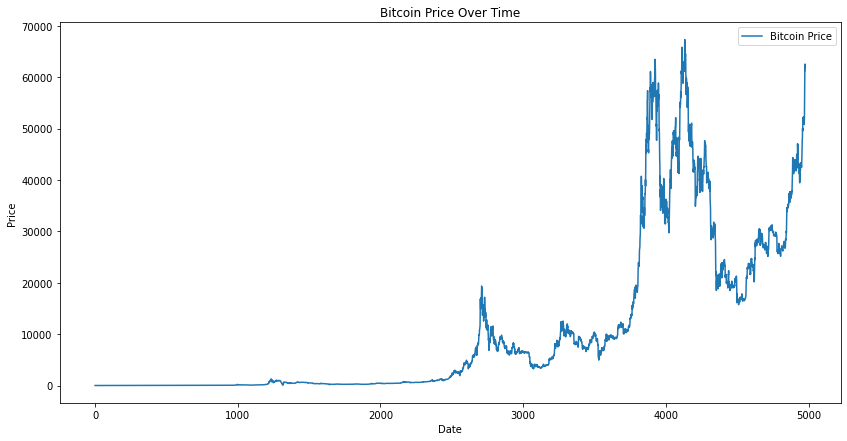

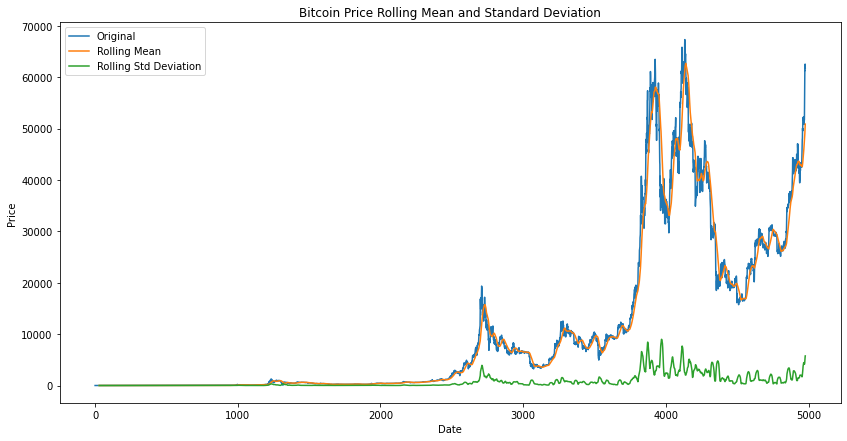

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(btc['close'], label='Bitcoin Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

window_size = 30
rolling_mean = btc['close'].rolling(window=window_size).mean()
rolling_std = btc['close'].rolling(window=window_size).std()

# Plot rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(btc['close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std Deviation')
plt.title('Bitcoin Price Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Autocorrelation Function (ACF) Plot
This section generates and displays the Autocorrelation Function (ACF) plot for the cryptocurrency price data. The ACF plot shows the correlation between the cryptocurrency price at different lags.

The first is for a lag of 50, and the second is for a lag of 100.

#### Understand the Results
Both of these are gradual, meaning that autocorrelation could be applied instead of a moving average filter.  Since we are doing deep learning, we will forego this, but it is useful to know that with looking back at past data, we can justify why current data is the way it is.

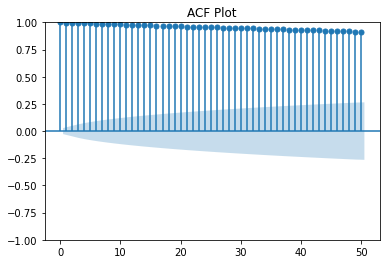

In [22]:
plot_acf(btc['close'], lags=50)
plt.title("ACF Plot (Lag of 50)")
plt.show()

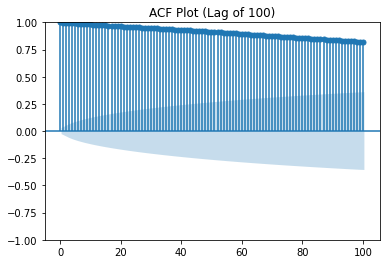

In [23]:
plot_acf(btc['close'], lags=100)
plt.title("ACF Plot (Lag of 100)")
plt.show()

#### Calculating Price Changes and Histogram Visualization
In this section, we calculate the daily price changes of the cryptocurrency and visualize their distribution using a histogram.

As we can see, many days of price yielded little change.  The days of little price movement were likely in the early days of trading, when Bitcoin was worth less than a dollar..

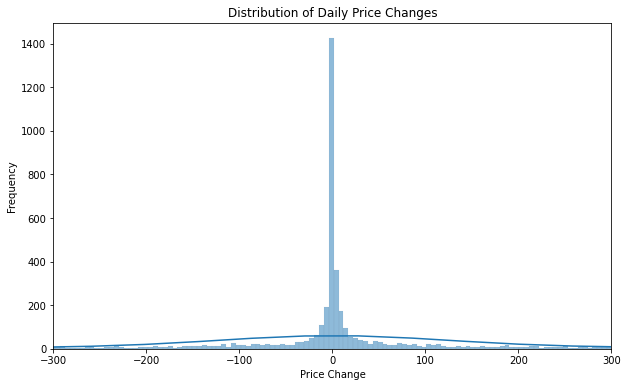

In [42]:
btc['Price_Change'] = btc['close'].diff()

plt.figure(figsize=(10, 6))
sns.histplot(btc['Price_Change'], kde=True)
plt.title('Distribution of Daily Price Changes')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.xlim(-300, 300)
plt.show()

## Correlation Matrices
We will now study the correlation between price in the future compared to the current price.

We will look at 1 day out, 50 days out, and 100 days out correlation.  Most columns should show 1.0 correlation, since they are price points on the same day.  Primarily we are paying attention to future close vs all other values.

### Close Price Next Day
As expected, the next day close price strongly correlates.

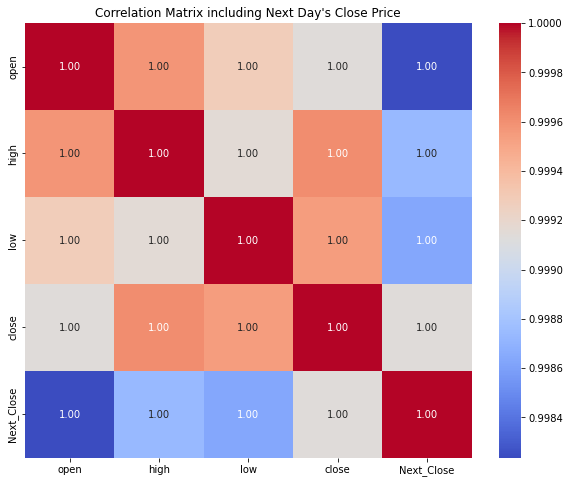

In [36]:
btc['Next_Close'] = btc['close'].shift(-1)

correlation_matrix = btc[['open', 'high', 'low', 'close', 'Next_Close']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including Next Day\'s Close Price')
plt.show()

### Close Price 50 Days Out
The close price 50 days out correlates very strongly as well.  Using 50 days of price data to predict the next day might be a good candidate for feature selection.

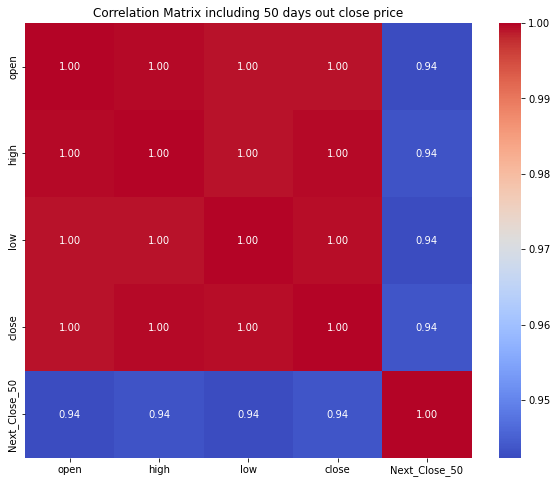

In [37]:
btc['Next_Close_50'] = btc['close'].shift(-50)

correlation_matrix = btc[['open', 'high', 'low', 'close', 'Next_Close_50']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including 50 days out close price')
plt.show()

### Close Price 100 Days Out
The close price 100 days out correlates very strongly as well.  Using 100 days of price data to predict the next day might also be a good candidate for feature selection.

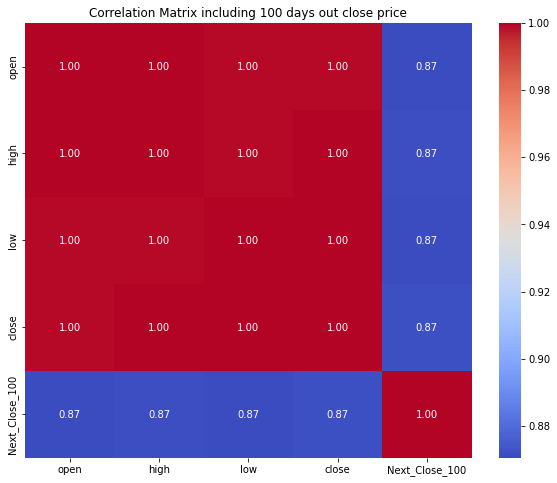

In [38]:
btc['Next_Close_100'] = btc['close'].shift(-100)

correlation_matrix = btc[['open', 'high', 'low', 'close', 'Next_Close_100']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including 100 days out close price')
plt.show()

## What Features to Use
Based on the above matrices, I think that using 50 days of price data will be ideal, since price still correlates strongly.

### Additional Feature: 30 day Exponential Moving Average
We will also add a 30 day EMA to the features, so that the algorithm can understand what the current trend of price is.

In [44]:
btc['30d_EMA'] = btc['close'].ewm(span=30, adjust=False).mean()

### Examining the Current State of the Data
There is an accidental index column of 1970-01-01.  The index column should be the date, so we will correct that.

In [45]:
btc.head()

,ticker,date,open,high,low,close,Price_Change,Next_Close,Next_Close_50,Next_Close_100,30d_EMA
1970-01-01,BTC,2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,0.08584,0.06160,0.1320,0.049510
1970-01-01,BTC,2010-07-18,0.04951,0.08585,0.04951,0.08584,0.03633,0.08080,0.06160,0.1503,0.051854
1970-01-01,BTC,2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.00504,0.07474,0.06100,0.1877,0.053721
1970-01-01,BTC,2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.00606,0.07921,0.06200,0.1731,0.055077
1970-01-01,BTC,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.00447,0.05050,0.06111,0.1900,0.056634


In [47]:
if 'date' in btc.columns:
    btc.set_index('date', inplace=True)

Looking better!  Let's also remove the ticker column, as we are just looking at Bitcoin, so it is useless.

In [48]:
btc.head()

,ticker,open,high,low,close,Price_Change,Next_Close,Next_Close_50,Next_Close_100,30d_EMA
date,,,,,,,,,,
2010-07-17,BTC,0.04951,0.04951,0.04951,0.04951,NaN,0.08584,0.06160,0.1320,0.049510
2010-07-18,BTC,0.04951,0.08585,0.04951,0.08584,0.03633,0.08080,0.06160,0.1503,0.051854
2010-07-19,BTC,0.08584,0.09307,0.07723,0.08080,-0.00504,0.07474,0.06100,0.1877,0.053721
2010-07-20,BTC,0.08080,0.08181,0.07426,0.07474,-0.00606,0.07921,0.06200,0.1731,0.055077
2010-07-21,BTC,0.07474,0.07921,0.06634,0.07921,0.00447,0.05050,0.06111,0.1900,0.056634


In [50]:
btc.drop(columns=['ticker'], inplace=True)

Finally, let's also remove the future close prices, since we don't want the model to cheat by looking ahead.  Next_Close is technically what the prediction should be.

In [51]:
btc.head()

,open,high,low,close,Price_Change,Next_Close,Next_Close_50,Next_Close_100,30d_EMA
date,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,0.08584,0.06160,0.1320,0.049510
2010-07-18,0.04951,0.08585,0.04951,0.08584,0.03633,0.08080,0.06160,0.1503,0.051854
2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.00504,0.07474,0.06100,0.1877,0.053721
2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.00606,0.07921,0.06200,0.1731,0.055077
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.00447,0.05050,0.06111,0.1900,0.056634


In [52]:
btc.drop(columns=['Next_Close', 'Next_Close_50', 'Next_Close_100'], inplace=True)
btc.head()

,open,high,low,close,Price_Change,30d_EMA
date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,0.049510
2010-07-18,0.04951,0.08585,0.04951,0.08584,0.03633,0.051854
2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.00504,0.053721
2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.00606,0.055077
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.00447,0.056634


# Model Building and Training

### Importing Anticipated Libraries
While we will run into other libraries, there are a few I expect to use.  These are libraries for splitting data, designing neural networks, and libraries for training processes.

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

In [58]:
btc['Next_Close'] = btc['close'].shift(-1)

### Assembling the Data
X is all of our remaining features (OHLC, EMA, and Price Change)

y is the next close, so 24 hours out from the current close.

Drop the last row from both 'X' and 'y' to remove the NaN target (since we don't know tomorrow's price)

In [59]:
X = btc.drop(['Next_Close'], axis=1)  # All columns except 'Next_Close'
y = btc['Next_Close']

In [60]:
X = X[:-1]
y = y[:-1]

## Train and Validation Split
The training data will be 80%, and 20% will be saved for validation.  This split will give us a few thousand days to train on, and hundreds to test on.

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### Combining the Data into Timestep Snapshots
Since we are going to be providing the model with 50 days of data at once, we need to create data that is a shape of (50, 6). This is because there are 6 features per day and 50 days.

In [64]:
def create_sequences(X, y, time_steps=50):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [85]:
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps=50)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps=50)

## First Model Architecture
The chosen architecture comprises two LSTM layers with dropout regularization followed by two fully connected dense layers.

#### LSTM Layers:
- Two LSTM layers are utilized for capturing temporal dependencies in the cryptocurrency data.
- The first LSTM layer has 50 units and is set to return sequences to feed into the next layer.
- The second LSTM layer also has 50 units but is configured to return only the final output sequence.
- LSTM layers are effective for modeling sequential data like time series due to their ability to retain information over time.

#### Dropout Layers:
- Dropout layers with a dropout rate of 0.2 are incorporated after each LSTM layer.
- Dropout regularization helps prevent overfitting by randomly dropping a fraction of input units during training, forcing the network to learn more robust features.

#### Dense Layers:
- Following the LSTM layers, two dense layers are added.
- The first dense layer consists of 25 units, providing a non-linear transformation of the LSTM output.
- The final dense layer with a single unit aims to predict the next day's closing price.

This architecture is chosen for its ability to effectively capture temporal patterns in the cryptocurrency data while mitigating overfitting through dropout regularization. The use of LSTM layers allows the model to learn from historical price sequences, potentially enabling it to make accurate predictions about future price movements. Additionally, the presence of dropout layers enhances the model's generalization capability, thereby improving its robustness to unseen data.

In [91]:
model_a = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 6)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

#### Compiling
We will use an Adam optimizer with a low learning rate to aid training stability

In [92]:
optimizer = Adam(learning_rate=1e-10, clipvalue=1.0)
model_a.compile(optimizer='adam', loss='mse')

#### Training
Now we will train for 1 epoch.  As we can see, loss is 'nan'.  This shows that training is unstable and troubleshooting is needed.

In [93]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=1,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

99/99 [==============================] - 4s 21ms/step - loss: nan - val_loss: nan


### Troubleshooting with a Simple Model
We will use a very simple model to see if this can fix the instability, implying there are issues with the model.

In [119]:
from tensorflow.keras.initializers import GlorotUniform, RandomNormal

model_simplified = Sequential([
    LSTM(20, input_shape=(50, 6), kernel_initializer=RandomNormal()),
    Dense(1, kernel_initializer=RandomNormal())
])

#### Compiling
This was compiled with both Adam and SGD.  Neither fix the issue.  

In [120]:
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
# optimizer = SGD(lr=0.01, momentum=0.9)
model_simplified.compile(optimizer=optimizer, loss='mse')

#### Training
As we can see below, loss is still nan.

In [121]:
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    epochs=1,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

246/246 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan


### Model for Troubleshooting
This model contains various potential fixes for the training issue.  For one, there is batch normalization in between most layers, which can help with stabilizing training.  Kernels are also initialized to more neural values to ensure chance isn't causing an issue.

In [137]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal

model_simplified = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 6), kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(1, kernel_initializer=HeNormal())
])

#### Compiling
This model will use Adam with a lower learning rate, and an early stopping parameter in case training goes awry.

In [138]:
optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)
model_simplified.compile(optimizer=optimizer, loss='mse')

In [139]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_test = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

#### Training
This model still runs into the nan issue.  At this point, the issue probably has to do with the data not being scaled correctly.  Afterall, Bitcoin price data ranges widely (from under $1 to over $60,000)

In [141]:
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    epochs=1,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

246/246 [==============================] - 4s 14ms/step - loss: nan - val_loss: nan


### Feature Scaling
We will cale the data between 0 and 1, for both training and validation.  This will likely help stabilize training and prevent nan values.

In [155]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

#### Finding a NaN value in the data
Additionally, there is a nan value that may be causing issues.  We will remove it below.

In [162]:
nan_in_features = X.isnull().sum().sum()
print(f"Total NaN values in features: {nan_in_features}")

nan_in_target = y.isnull().sum()
print(f"Total NaN values in target: {nan_in_target}")

Total NaN values in features: 1
Total NaN values in target: 0


In [163]:
combined = X.join(y, how='inner')
combined_clean = combined.dropna()

X_train_clean = combined_clean.drop([y.name], axis=1)
y_train_clean = combined_clean[y.name]

#### Reconstructing Sequences
Now that the data is fixed up, we will recombine it into 50 day chunks.

In [164]:
X_train_seq, y_train_seq = create_sequences(X_train_clean, y_train_clean, time_steps=50)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps=50)

We will use the same, "safe" model from before.  It might not be complex enough to solve the issue, and is more for troubleshooting.

In [168]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal

model_simplified = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 6), kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(1, kernel_initializer=HeNormal())
])

#### Compiling
We will use a standard Adam, as the learning rate was likely not the issue.

In [169]:
optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model_simplified.compile(optimizer=optimizer, loss='mse')

#### Training
It appears the model is working, but with outlandish loss values.  Fortunately, it has served its purpose and proven that we have fixed the instability issues.

In [170]:
history = model_simplified.fit(
    X_train_seq, y_train_seq,
    epochs=1,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

308/308 [==============================] - 7s 16ms/step - loss: 354597312.0000 - val_loss: 1273880704.0000


### Stable Model Architecture
This model is very similar to the previous model, but is a fresh architecture.  It is designed to be stable during training via the initializer and batch normalization.

In [172]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal

model_a = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 6), kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(1, kernel_initializer=HeNormal())
])

#### Compiling
We will use MAE instead of MSE, since MSE extremely large and may be confusing the model.

In [173]:
# optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model_a.compile(optimizer='Adam', loss='mean_absolute_error')

#### Training
We will train this model for a total of 199 epochs.  At the end, it appears that this model was not well enough designed to solve the problem, as it's loss remains in the thousands, and cannot get better than roughly 6000 loss.

In [174]:
history = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=1,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

308/308 [==============================] - 7s 16ms/step - loss: 10671.4082 - val_loss: 33506.8633


In [175]:
history = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=99,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

Epoch 1/99
308/308 [==============================] - 5s 15ms/step - loss: 10658.9365 - val_loss: 33486.2969
Epoch 2/99
308/308 [==============================] - 5s 15ms/step - loss: 10634.6992 - val_loss: 33417.5234
Epoch 3/99
308/308 [==============================] - 5s 15ms/step - loss: 10600.5137 - val_loss: 33370.4844
Epoch 4/99
308/308 [==============================] - 4s 14ms/step - loss: 10559.9756 - val_loss: 33418.4570
Epoch 5/99
308/308 [==============================] - 4s 14ms/step - loss: 10514.2734 - val_loss: 33503.8633


In [176]:
history_2 = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=99,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/99
308/308 [==============================] - 4s 14ms/step - loss: 10565.4199 - val_loss: 33323.1562
Epoch 2/99
308/308 [==============================] - 4s 14ms/step - loss: 10528.7178 - val_loss: 33277.1406
Epoch 3/99
308/308 [==============================] - 4s 14ms/step - loss: 10486.4375 - val_loss: 33372.7695
Epoch 4/99
308/308 [==============================] - 4s 15ms/step - loss: 10437.6250 - val_loss: 33208.7500
Epoch 5/99
308/308 [==============================] - 4s 14ms/step - loss: 10389.9844 - val_loss: 32928.1914
Epoch 6/99
308/308 [==============================] - 5s 15ms/step - loss: 10324.5420 - val_loss: 32810.1406
Epoch 7/99
308/308 [==============================] - 4s 14ms/step - loss: 10263.2119 - val_loss: 32629.9570
Epoch 8/99
308/308 [==============================] - 4s 14ms/step - loss: 10212.3477 - val_loss: 32639.2578
Epoch 9/99
308/308 [==============================] - 4s 14ms/step - loss: 10138.5625 - val_loss: 32527.3320
Epoch 10/99
308/308

In [178]:
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
model_a.compile(optimizer=optimizer, loss='mean_absolute_error')

In [179]:
history_2 = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=99,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/99
308/308 [==============================] - 8s 18ms/step - loss: 9086.9248 - val_loss: 24968.9668
Epoch 2/99
308/308 [==============================] - 5s 15ms/step - loss: 8833.3350 - val_loss: 24170.8145
Epoch 3/99
308/308 [==============================] - 5s 16ms/step - loss: 9151.2568 - val_loss: 26791.9746
Epoch 4/99
308/308 [==============================] - 5s 16ms/step - loss: 10120.7441 - val_loss: 27958.1699
Epoch 5/99
308/308 [==============================] - 5s 15ms/step - loss: 10145.1504 - val_loss: 27934.9258
Epoch 6/99
308/308 [==============================] - 5s 15ms/step - loss: 10187.4854 - val_loss: 29075.5117
Epoch 7/99
308/308 [==============================] - 4s 14ms/step - loss: 8757.4385 - val_loss: 20484.3750
Epoch 8/99
308/308 [==============================] - 4s 14ms/step - loss: 8159.1919 - val_loss: 22546.9570
Epoch 9/99
308/308 [==============================] - 4s 14ms/step - loss: 8638.8193 - val_loss: 23918.0195
Epoch 10/99
308/308 [====

## Correcting Training Errors in Data Preprocessing
At this point I realized the sequenced data was not factoring in the feature scaling.

#### Updating the Sequences Function to Be Compatible with the new Feature Scaled Data
We have to make minor adjustments to the function to make it useable with the feature scaled data, but it does the same thing still.

In [185]:
def create_sequences(X, y, time_steps=50):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

### Assembling the Feature Scaled, Cleaned, Split Dataset
In this section, the cryptocurrency data is preprocessed again for training the LSTM model. This involves handling missing values, scaling the features and target variable, splitting the data into training and validation sets, and creating sequences for input to the LSTM model.

In [186]:
btc_clean = btc.dropna()
X_clean = btc_clean.drop(['Next_Close'], axis=1)
y_clean = btc_clean['Next_Close']

scaler = MinMaxScaler()

X_train, X_val, y_train, y_val = train_test_split(X_clean, y_clean, test_size=0.2, shuffle=False)

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled.flatten(), time_steps=50)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled.flatten(), time_steps=50)

### A Simple Model for Testing the New Data Fixes
This is just a simple model to see how the new feature scaled data works with the training process.  It is not meant to be a serious model.

Architecture Explanation:
#### Flatten Layer:
- The input shape of this model is (50, 6), which represents a sequence length of 50 time steps and 6 features.
- The Flatten layer reshapes this input into a one-dimensional array to be fed into the subsequent fully connected layers.

#### Dense Layers:
- Two dense layers are added with ReLU activation functions.
- The first dense layer consists of 64 units, providing non-linearity to the model.
- The second dense layer has 32 units, further transforming the data to capture complex patterns.


#### Output Layer:
- The final dense layer consists of a single unit, responsible for predicting the next day's closing price.


In [187]:
from tensorflow.keras.layers import Flatten

model_c = Sequential([
    Flatten(input_shape=(50, 6)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

#### Compiling
This model is compiled with basic parameters.

In [188]:
model_c.compile(optimizer='adam', loss='mse')

#### Training
This model will be trained for 310 epochs to see if any errors occur.  Once again, this model should not perform well, as it is very simple.

In [189]:
history_c = model_c.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/10
123/123 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 2/10
123/123 [==============================] - 0s 1ms/step - loss: 9.5927e-04 - val_loss: 0.0031
Epoch 3/10
123/123 [==============================] - 0s 1ms/step - loss: 6.8203e-04 - val_loss: 0.0106
Epoch 4/10
123/123 [==============================] - 0s 1ms/step - loss: 8.4248e-04 - val_loss: 0.0044
Epoch 5/10
123/123 [==============================] - 0s 1ms/step - loss: 6.1547e-04 - val_loss: 0.0032
Epoch 6/10
123/123 [==============================] - 0s 1ms/step - loss: 4.4055e-04 - val_loss: 0.0050
Epoch 7/10
123/123 [==============================] - 0s 992us/step - loss: 8.1387e-04 - val_loss: 0.0038
Epoch 8/10
123/123 [==============================] - 0s 1ms/step - loss: 4.2929e-04 - val_loss: 0.0031
Epoch 9/10
123/123 [==============================] - 0s 1ms/step - loss: 3.0520e-04 - val_loss: 0.0041
Epoch 10/10
123/123 [==============================] - 0s 992us/st

In [190]:
history_c_2 = model_c.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/100
123/123 [==============================] - 0s 1ms/step - loss: 3.4127e-04 - val_loss: 0.0016
Epoch 2/100
123/123 [==============================] - 0s 975us/step - loss: 2.8797e-04 - val_loss: 0.0075
Epoch 3/100
123/123 [==============================] - 0s 984us/step - loss: 4.9528e-04 - val_loss: 0.0020
Epoch 4/100
123/123 [==============================] - 0s 959us/step - loss: 2.3103e-04 - val_loss: 0.0015
Epoch 5/100
123/123 [==============================] - 0s 967us/step - loss: 2.8718e-04 - val_loss: 0.0014
Epoch 6/100
123/123 [==============================] - 0s 992us/step - loss: 3.3239e-04 - val_loss: 0.0013
Epoch 7/100
123/123 [==============================] - 0s 984us/step - loss: 2.8030e-04 - val_loss: 0.0087
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 6.5171e-04 - val_loss: 0.0046
Epoch 9/100
123/123 [==============================] - 0s 993us/step - loss: 6.3567e-04 - val_loss: 0.0018
Epoch 10/100
123/123 [===================

In [191]:
history_c = model_c.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/200
123/123 [==============================] - 0s 1ms/step - loss: 1.2824e-04 - val_loss: 8.8165e-04
Epoch 2/200
123/123 [==============================] - 0s 1ms/step - loss: 1.2533e-04 - val_loss: 0.0011
Epoch 3/200
123/123 [==============================] - 0s 992us/step - loss: 1.2320e-04 - val_loss: 7.7445e-04
Epoch 4/200
123/123 [==============================] - 0s 959us/step - loss: 1.8474e-04 - val_loss: 9.5149e-04
Epoch 5/200
123/123 [==============================] - 0s 1ms/step - loss: 1.2895e-04 - val_loss: 0.0014
Epoch 6/200
123/123 [==============================] - 0s 992us/step - loss: 1.3123e-04 - val_loss: 7.6970e-04
Epoch 7/200
123/123 [==============================] - 0s 984us/step - loss: 1.2483e-04 - val_loss: 9.2910e-04
Epoch 8/200
123/123 [==============================] - 0s 984us/step - loss: 1.3815e-04 - val_loss: 0.0011
Epoch 9/200
123/123 [==============================] - 0s 984us/step - loss: 1.3920e-04 - val_loss: 0.0016
Epoch 10/200
123/123 [=

### Returning to the Original Stable Model
Now that it seems the data is ready for training, we will use the LSTM, Batch Normalization and Dropout model from earlier.  This is the same architecture, and should do well with stability. 

In [192]:
model_a2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 6), kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(1, kernel_initializer=HeNormal())
])

#### Compiling
We will compile the model with a typical optimizer and loss function.

In [193]:
model_a.compile(optimizer='adam', loss='mse')

#### Training
We will train for 100 epochs with the regular early stopping test.  This early stopping test ended up preventing training, so we will end up removing it after 6 epochs.

In [194]:
history_a2 = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

Epoch 1/100
246/246 [==============================] - 6s 16ms/step - loss: 48739180.0000 - val_loss: 21676106.0000
Epoch 2/100
246/246 [==============================] - 3s 14ms/step - loss: 35591672.0000 - val_loss: 22509996.0000
Epoch 3/100
246/246 [==============================] - 3s 14ms/step - loss: 32945886.0000 - val_loss: 24799568.0000


In [195]:
history_a2 = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_test],
    verbose=1
)

Epoch 1/100
246/246 [==============================] - 3s 14ms/step - loss: 35287168.0000 - val_loss: 17402268.0000
Epoch 2/100
246/246 [==============================] - 3s 14ms/step - loss: 32620658.0000 - val_loss: 24000076.0000
Epoch 3/100
246/246 [==============================] - 3s 14ms/step - loss: 30456530.0000 - val_loss: 21725264.0000


In [196]:
history_a2 = model_a.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/100
246/246 [==============================] - 3s 14ms/step - loss: 32667312.0000 - val_loss: 21887404.0000
Epoch 2/100
246/246 [==============================] - 4s 15ms/step - loss: 30306316.0000 - val_loss: 25436006.0000
Epoch 3/100
246/246 [==============================] - 4s 14ms/step - loss: 28342068.0000 - val_loss: 23430080.0000
Epoch 4/100
246/246 [==============================] - 4s 14ms/step - loss: 26552834.0000 - val_loss: 21819736.0000
Epoch 5/100
246/246 [==============================] - 4s 14ms/step - loss: 24896186.0000 - val_loss: 20966328.0000
Epoch 6/100
246/246 [==============================] - 3s 14ms/step - loss: 23338258.0000 - val_loss: 19802652.0000
Epoch 7/100
246/246 [==============================] - 4s 14ms/step - loss: 21878702.0000 - val_loss: 19246742.0000
Epoch 8/100
246/246 [==============================] - 4s 14ms/step - loss: 20512322.0000 - val_loss: 19296508.0000
Epoch 9/100
246/246 [==============================] - 4s 14ms/step - lo

### Training Results
After this model is trained for hundreds of epochs, it reaches a very acceptable loss of 0.1866.  At this point, the model is trained.

In [197]:
model_a2.save('models/model_a2')

INFO:tensorflow:Assets written to: models/model_a2\assets


INFO:tensorflow:Assets written to: models/model_a2\assets


In [218]:
model_a.save('models/model_a')

INFO:tensorflow:Assets written to: models/model_a\assets


INFO:tensorflow:Assets written to: models/model_a\assets


In [229]:
model_c.save('models/model_c')

INFO:tensorflow:Assets written to: models/model_c\assets


INFO:tensorflow:Assets written to: models/model_c\assets


# Result

## Analysis of Model_A1
The original batch normalization model did alright, it seems to be

In [219]:
test_loss = model_a.evaluate(X_val_seq, y_val_seq, verbose=1)
print(f"Test Loss: {test_loss}")

30/30 [==============================] - 0s 6ms/step - loss: 2.7280
Test Loss: 2.727968454360962


In [220]:
predictions = model_a.predict(X_val_seq)

30/30 [==============================] - 1s 5ms/step


#### Inverse Transform
Inverse Transform of the prediction to get understandable results.

In [221]:
predictions_inverse = y_scaler.inverse_transform(predictions)
y_val_seq_inverse = y_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

#### Plotting Results
As we can see, this model was not good.  It managed to predict that price would be $-125,000.

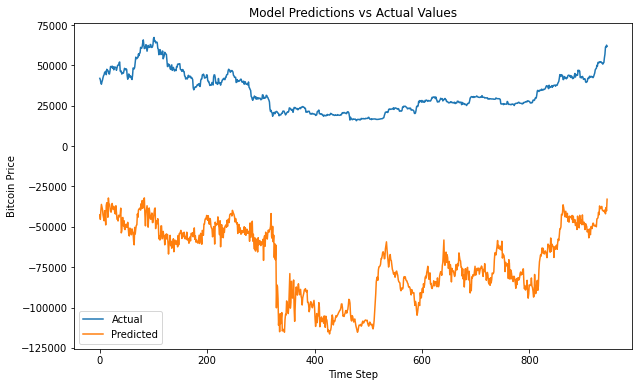

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val_seq_inverse, label='Actual')
plt.plot(predictions_inverse, label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

#### In-Depth Performance Metrics
Evidently, this model did a bad job, as seen by the low R squared value.

In [223]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val_seq, predictions)
rmse = mean_squared_error(y_val_seq, predictions)
r2 = r2_score(y_val_seq, predictions)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

MAE: 1.6374384610435146, RMSE: 2.727968596857917, R²: -72.44761462745277


## Analysis of Model_A2
Now we will perform the same analysis for the second model.

In [199]:
model_a2.compile(optimizer='adam', loss='mse')

#### Loss
This model has much better loss, meaning that this model is more promising.

In [200]:
test_loss = model_a2.evaluate(X_val_seq, y_val_seq, verbose=1)
print(f"Test Loss: {test_loss}")

30/30 [==============================] - 1s 6ms/step - loss: 0.0558
Test Loss: 0.05584470555186272


In [201]:
predictions = model_a2.predict(X_val_seq)

30/30 [==============================] - 1s 5ms/step


Once again, invert the predictions to get values out of.

In [211]:
predictions_inverse = y_scaler.inverse_transform(predictions)
y_val_seq_inverse = y_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

#### Plot
These predictions are pretty decent.  While they are detrended, they are following price volatility well.

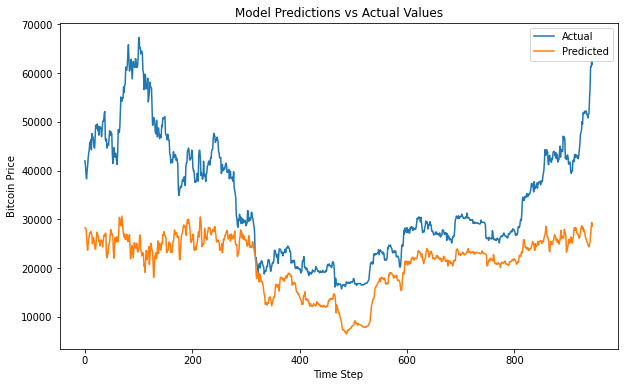

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val_seq_inverse, label='Actual')
plt.plot(predictions_inverse, label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

#### In-Depth Performance Metrics
- MAE is off because the model is not following price trend very well.
- RMSE is very large as well because of this
- R^2 is negative, which is suprising, but again might be because of how the price trend isn't followed

Despite these poor signs in the metrics, this model seems decent.

### Analysis of Model_C
For comparison, we will now look at how the simple dense layer-only model performed.

### Loss Analysis
Model_C has an impressively low loss.

In [224]:
test_loss = model_c.evaluate(X_val_seq, y_val_seq, verbose=1)
print(f"Test Loss: {test_loss}")

30/30 [==============================] - 0s 679us/step - loss: 0.0011
Test Loss: 0.0011133592342957854


#### Getting the Predictions

In [225]:
predictions = model_c.predict(X_val_seq)

30/30 [==============================] - 0s 641us/step


#### Inverting the Predictions for Understandability

In [226]:
predictions_inverse = y_scaler.inverse_transform(predictions)
y_val_seq_inverse = y_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

#### Plotting the Results
This model is impressive, and predicts price with extreme accuracy.

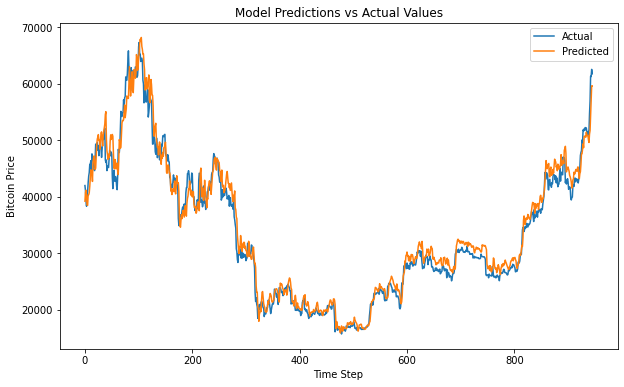

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val_seq_inverse, label='Actual')
plt.plot(predictions_inverse, label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [228]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val_seq, predictions)
rmse = mean_squared_error(y_val_seq, predictions)
r2 = r2_score(y_val_seq, predictions)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

MAE: 0.025338464491110088, RMSE: 0.0011133589245438094, R²: 0.970024010787325


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val_seq, predictions)
rmse = mean_squared_error(y_val_seq, predictions)
r2 = r2_score(y_val_seq, predictions)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Discussion/Conclusion

## Unexpected Good Performance
Upon evaluating the performance of different model architectures for predicting cryptocurrency prices, several key observations emerge.

## Performance Comparison:
#### Simple Model Performance:

Surprisingly, the simple model architecture, which comprises fully connected layers after flattening the input data, outperformed expectations.
Despite its straightforward design, the model exhibited a remarkable ability to predict price movements with unexpected accuracy, as evidenced by the final chart.
Although the model's predictions may be off in scale, it demonstrated an understanding of the relative movement of prices 24 hours ahead.
#### Advanced Model Performance:

In contrast, the more advanced models incorporating dropout layers and LSTM layers did not perform as well.
Despite their capacity to capture temporal dependencies and mitigate overfitting, these models failed to achieve the same level of accuracy as the simple model.
The discrepancy in performance highlights the complexity of predicting cryptocurrency prices and suggests that sophisticated architectures may not always yield superior results.

## Implications and Insights:
#### Model Interpretability:
The success of the simple model underscores the importance of interpretability in predictive modeling.
While complex architectures may offer greater flexibility, simpler models can often provide meaningful insights and practical utility.

#### Temporal Dependencies:
The surprising accuracy of the simple model suggests that temporal dependencies in cryptocurrency price data may not be as pronounced as anticipated.
This raises questions about the efficacy of sophisticated models in capturing subtle patterns in the data.

#### Further Research Directions:
The discrepancy in performance between simple and advanced models prompts further investigation into the underlying dynamics of cryptocurrency markets.
Future research could explore alternative features, model architectures, or preprocessing techniques to enhance predictive accuracy.
In conclusion, while the performance of different model architectures varied, the unexpected success of the simple model underscores the importance of empirical validation and the need for a nuanced understanding of the underlying data. As the cryptocurrency landscape continues to evolve, leveraging diverse modeling approaches and embracing simplicity may hold the key to unlocking valuable insights and improving predictive accuracy.





